# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np
import seaborn as sns
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *
import itertools

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Import Data 

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-16 13:47:23.851641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 13:47:23.851698: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 13:47:23.851720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-16 13:47:23.851981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [4]:
training_df['review_ls'] = training_df['review'].apply(lambda x: x.split(" "))
vocabulary = list(itertools.chain(*training_df['review_ls']))
VOCAB_SIZE = len(vocabulary)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)
encoder.adapt(X_train)

2022-03-16 13:47:24.668869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Baseline

In [10]:
epochs = 1

base_model = keras.Sequential([
        layers.Input(shape=(90,), name="Input", dtype=tf.string),
        encoder,
        tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
        layers.Dense(64,activation='relu', dtype=tf.float32),
        layers.Dense(30,activation='relu', dtype=tf.float32),
        layers.Dropout(0.2),
        layers.Dense(1,activation=relu_advanced)],name='2.6-Base-Reg-Trained')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mse','mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)
performance_evaluation(test_ds, y_test, base_model)

ValueError: Can not squeeze dim[1], expected a dimension of 1, got 90 for '{{node text_vectorization/Squeeze}} = Squeeze[T=DT_STRING, squeeze_dims=[-1]](text_vectorization/StaticRegexReplace)' with input shapes: [?,90].

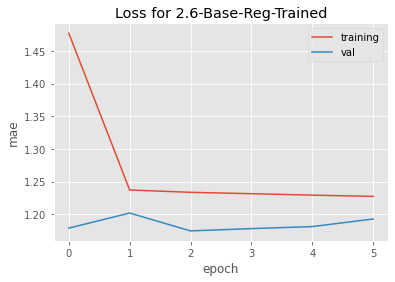

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.6-Base-Reg-Trained.png


In [6]:
plot_loss(base_history,base_model)

In [8]:
performance_evaluation(test_ds, y_test, base_model)

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [128,85,1] vs. shape[1] = [128,99,1] [Op:ConcatV2] name: concat

In [ ]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

## RNN

In [ ]:
embed
embed(X_train).shape

In [ ]:
rnn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    layers.Bidirectional(layers.SimpleRNN(64, activation='tanh',return_sequences=False)),
    # layers.SimpleRNN(5, activation='tanh',return_sequences=False),
    layers.Dense(10, activation='relu'),
    # layers.Dropout(0.3),
    # layers.Dense(10, activation='relu'),
    # layers.Dropout(0.3),
    # layers.Dense(5, activation='tanh'),
    layers.Dropout(0.05),
    layers.Dense(1,activation=relu_advanced)
],name='2.6-RNN-Reg-Bidirect-Trained')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['mse','mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

In [ ]:
rnn_model.summary()

In [ ]:
plot_loss(rnn_history,rnn_model)

In [ ]:
performance_evaluation(X_test, y_test, rnn_model)

In [ ]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))

In [ ]:
# max(y_pred)

In [ ]:
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (128,1)),
    layers.Bidirectional(layers.GRU(64, activation='tanh',return_sequences=True)),
    layers.GRU(4, activation='tanh',return_sequences=False),
    layers.Dropout(0.2),
    # layers.Dense(5,activation='relu'),
    layers.Dense(1,activation=relu_advanced)
],name='2.1-GRU-Reg-Bidirect-NNLM')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

In [ ]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

In [ ]:
plot_loss(gru_history,gru_model)

In [ ]:
performance_evaluation(X_test, y_test, gru_model)

In [ ]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## LSTM

In [ ]:
lstm_model = tf.keras.Sequential([
    encoder,
        tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    layers.Bidirectional(layers.LSTM(64, activation='tanh',return_sequences=True)),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    # layers.Dense(5,activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1,activation=relu_advanced)
],name='2.6-LSTM-Reg-Bidirect-Trained')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

In [ ]:
performance_evaluation(X_test, y_test, lstm_model)

In [ ]:
plot_loss(lstm_history,lstm_model)

In [ ]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))